# Import Libraries



In [138]:
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder,OrdinalEncoder
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00


# Load datasets

In [111]:
train_df = pd.read_csv('aug_train.csv')
test_df = pd.read_csv('aug_test.csv')

# Data Cleaning

In [112]:
# Handling datatype

train_df['city_development_index'] = train_df['city_development_index'] * 100
test_df['city_development_index'] = test_df['city_development_index'] * 100

test_df['city'] = test_df['city'].astype(str)
train_df['city'] = train_df['city'].astype(str)

test_df['company_size'] = test_df['company_size'].astype(str)
train_df['company_size'] = train_df['company_size'].astype(str)

train_df['experience'] = train_df['experience'].replace({'>20': '21', '<1': '0'}).astype(float)
test_df['experience'] = test_df['experience'].replace({'>20': '21', '<1': '0'}).astype(float)

train_df['company_size'] = train_df['company_size'].replace({'<10':'Emerging_TinyScale','50-99':'TinyScale','100-500':'SmallScale',
                                                             '500-999':'Intermediate-MediumScale','1000-4999':'MediumScale',
                                                             '5000-9999':'LargeScale', '10000+': 'Corporate', '10/49': 'Emerging_SmallScale'})
test_df['company_size'] = test_df['company_size'].replace({'<10':'Emerging_TinyScale','50-99':'TinyScale','100-500':'SmallScale',
                                                             '500-999':'Intermediate-MediumScale','1000-4999':'MediumScale',
                                                             '5000-9999':'LargeScale', '10000+': 'Corporate', '10/49': 'Emerging_SmallScale'})

train_df['last_new_job'] = train_df['last_new_job'].replace({'>4': '5', 'never':'0'}).astype(float)
test_df['last_new_job'] = test_df['last_new_job'].replace({'>4': '5','never':'0' }).astype(float)

In [113]:
train_df['company_size'].value_counts()

,count
company_size,
nan,5938
TinyScale,3083
SmallScale,2571
Corporate,2019
Emerging_SmallScale,1471
MediumScale,1328
Emerging_TinyScale,1308
Intermediate-MediumScale,877
LargeScale,563


In [114]:
# Drop unwanted columns
train_df = train_df.drop(columns=[ 'city'], errors='ignore')
test_df = test_df.drop(columns=[ 'city'], errors='ignore')

# Data Visualization



In [115]:
def descriptive_statistics(df):
    print("Numerical Columns Statistics:")
    print(df.describe())
    print("\nCategorical Columns Statistics:")
    print(df.describe(include=['object']))

descriptive_statistics(train_df)
descriptive_statistics(test_df)

Numerical Columns Statistics:
        enrollee_id  city_development_index    experience  last_new_job  \
count  19158.000000            19158.000000  19093.000000  18735.000000   
mean   16875.358179               82.884800     10.100141      2.000427   
std     9616.292592               12.336176      6.777024      1.675596   
min        1.000000               44.800000      0.000000      0.000000   
25%     8554.250000               74.000000      4.000000      1.000000   
50%    16982.500000               90.300000      9.000000      1.000000   
75%    25169.750000               92.000000     16.000000      3.000000   
max    33380.000000               94.900000     21.000000      5.000000   

       training_hours        target  
count    19158.000000  19158.000000  
mean        65.366896      0.249348  
std         60.058462      0.432647  
min          1.000000      0.000000  
25%         23.000000      0.000000  
50%         47.000000      0.000000  
75%         88.000000      0

In [116]:
# Checking for null values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()
missing_percent_train = (missing_values_train / len(train_df)) * 100
print("Missing Values in Train Dataset:\n")
for col, missing_count in missing_values_train.items():
    missing_percent = missing_percent_train[col]
    print(f"{col}: {missing_count} ({missing_percent:.2f}%)")
print("\nMissing Values in Test Dataset:")
print(missing_values_test)


Missing Values in Train Dataset:

enrollee_id: 0 (0.00%)
city_development_index: 0 (0.00%)
gender: 4508 (23.53%)
relevent_experience: 0 (0.00%)
enrolled_university: 386 (2.01%)
education_level: 460 (2.40%)
major_discipline: 2813 (14.68%)
experience: 65 (0.34%)
company_size: 0 (0.00%)
company_type: 6140 (32.05%)
last_new_job: 423 (2.21%)
training_hours: 0 (0.00%)
target: 0 (0.00%)

Missing Values in Test Dataset:
enrollee_id                 0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size                0
company_type              634
last_new_job               40
training_hours              0
dtype: int64


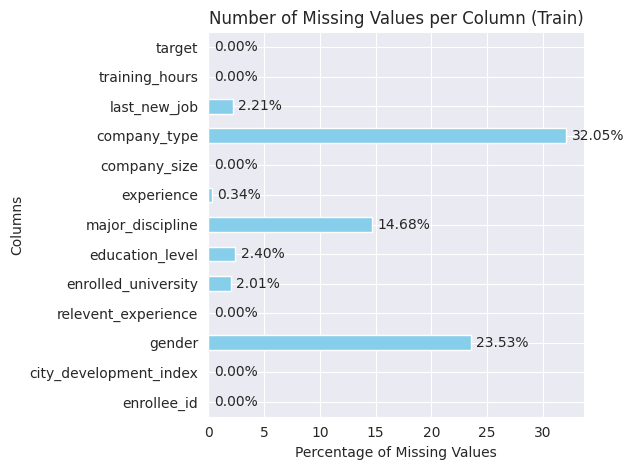

In [117]:
# Visualizing missing values
# Plot the missing values
ax = missing_percent_train.plot.barh(color='skyblue')

# Add percentage labels at the end of each bar
for index, value in enumerate(missing_percent_train):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', fontsize=10)

plt.title('Number of Missing Values per Column (Train)')
plt.ylabel('Columns')
plt.xlabel('Percentage of Missing Values')
plt.tight_layout()
plt.show()

## Null Value Treatment

In [118]:

# Columns to fill using mode
columns_mode_fill = ['experience', 'company_type', 'gender', 'major_discipline', 'education_level', 'enrolled_university']
for col in columns_mode_fill:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

# Fill 'last_new_job' using probability distribution (excluding '1')
job_dist = train_df[train_df['last_new_job'].notnull() & (train_df['last_new_job'] != 1)]['last_new_job'].value_counts(normalize=True)
train_df.loc[train_df['last_new_job'].isnull(), 'last_new_job'] = np.random.choice(
    job_dist.index,
    size=train_df['last_new_job'].isnull().sum(),
    p=job_dist.values
)

# Fill 'company_size' using weighted random sampling
valid_categories = ['TinyScale', 'SmallScale', 'Corporate', 'Emerging_SmallScale',
                    'MediumScale', 'Emerging_TinyScale', 'Intermediate-MediumScale', 'LargeScale']
probabilities = [0.34, 0.28, 0.17, 0.10, 0.05, 0.04, 0.02, 0.01]  # Adjusted based on category distribution

# Normalize probabilities to ensure they sum to 1
probabilities = np.array(probabilities)  # Convert to NumPy array for easier calculations
probabilities /= probabilities.sum()  # Normalize by dividing by the sum

train_df.loc[train_df['company_size'].isnull(), 'company_size'] = np.random.choice(
    valid_categories,
    size=train_df['company_size'].isnull().sum(),
    p=probabilities
)

# Cleaned Datasets

In [119]:
# Save cleaned datasets
train_df.to_csv('cleaned_train.csv', index=False)
test_df.to_csv('cleaned_test.csv', index=False)



# Exploratory Data Analysis (EDA)

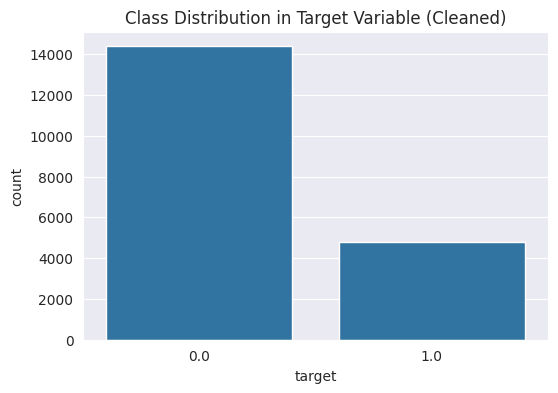

In [120]:
# Check Data Imbalance using cleaned dataset
plt.figure(figsize=(6,4))
sns.countplot(x=train_df['target'])
plt.title('Class Distribution in Target Variable (Cleaned)')
plt.show()



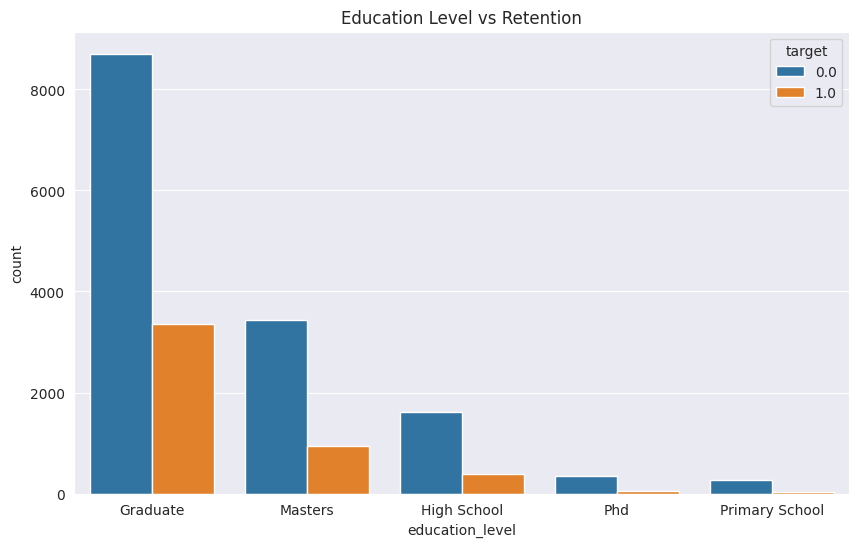

In [121]:
# Data Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='education_level', hue='target')
plt.title('Education Level vs Retention')
plt.show()



<Axes: xlabel='education_level', ylabel='count'>

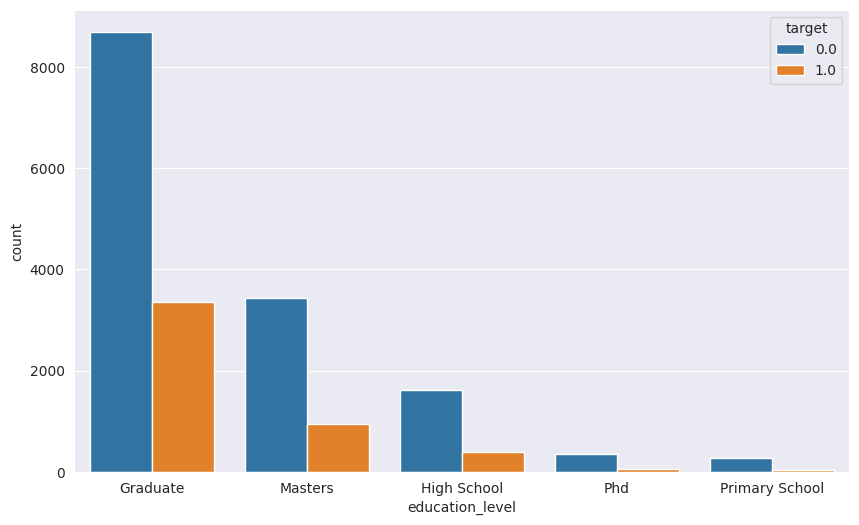

In [122]:
# Data Visualization
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='education_level', hue='target')



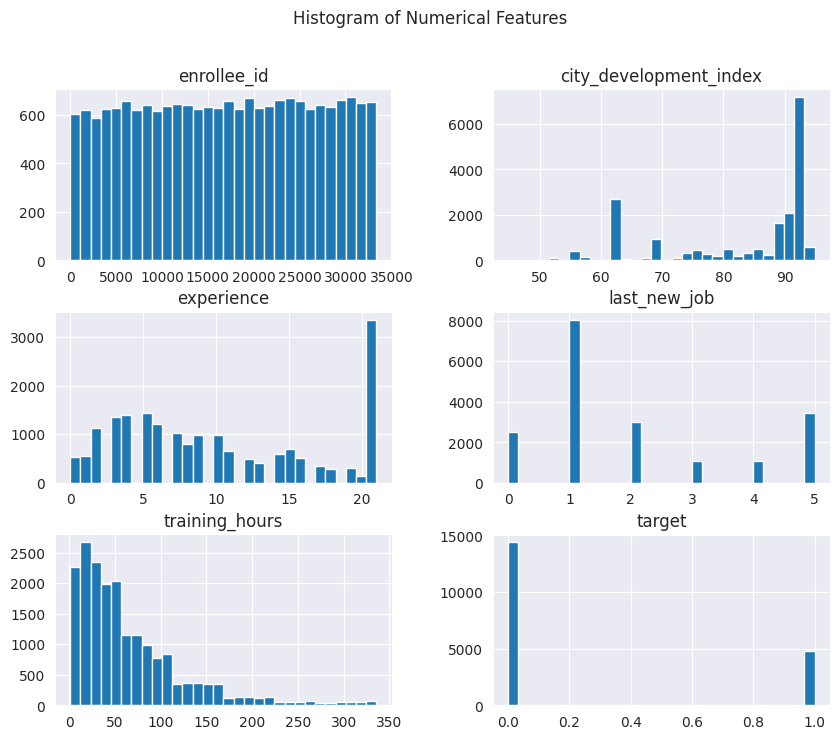

In [123]:
# Histogram for numerical columns
train_df.hist(figsize=(10, 8), bins=30)
plt.suptitle("Histogram of Numerical Features")
plt.show()



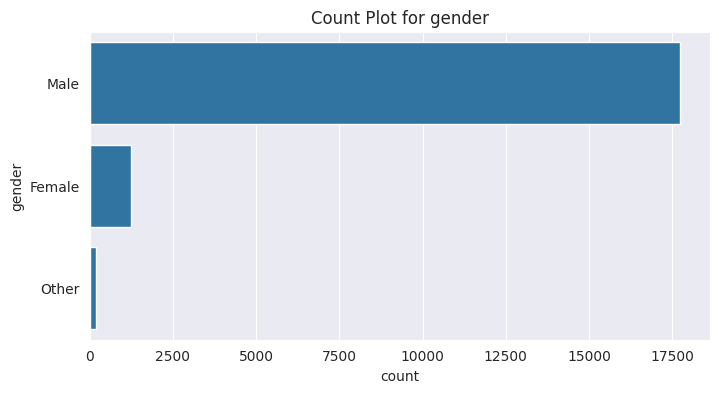

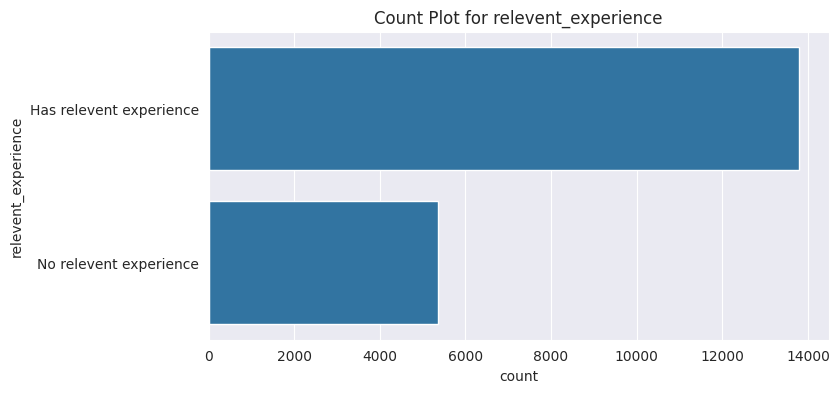

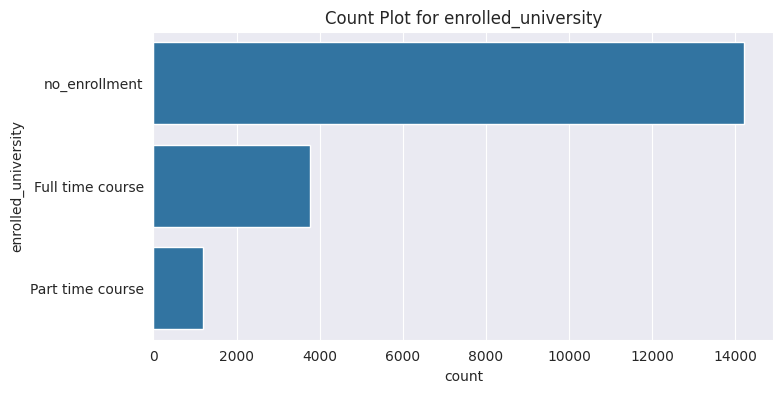

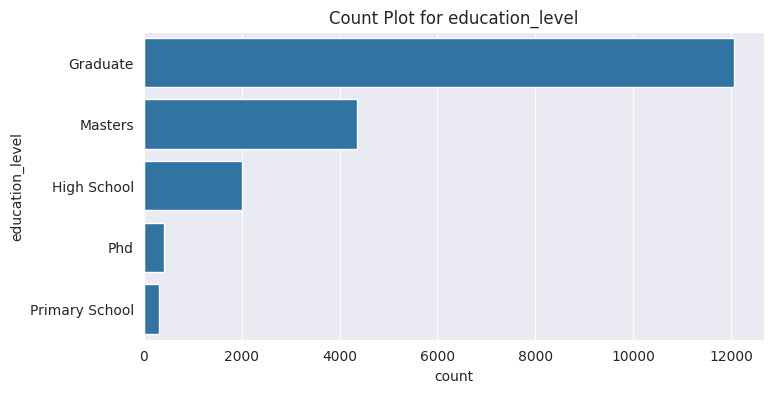

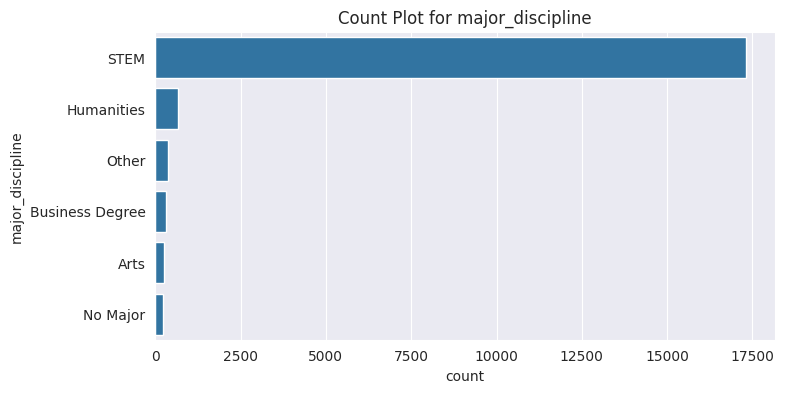

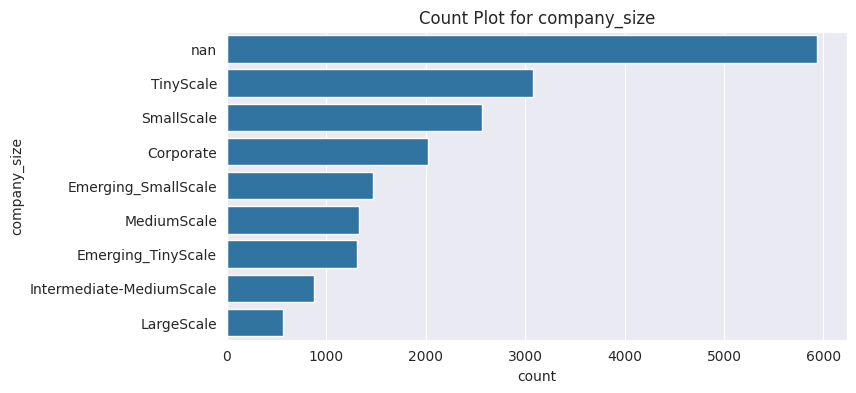

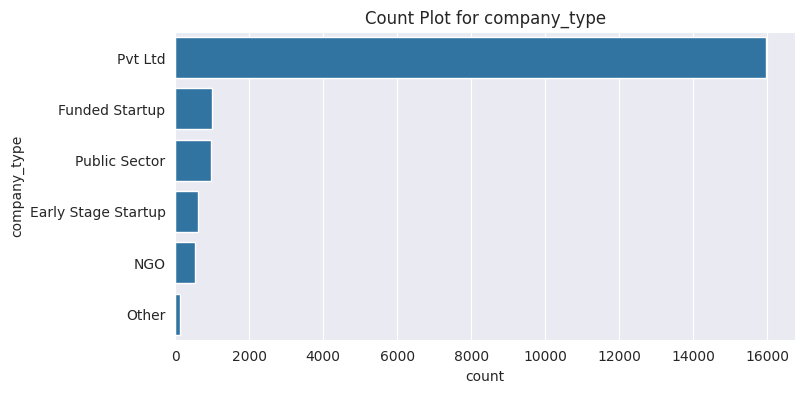

In [124]:
# Count plots for categorical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index)
    plt.title(f"Count Plot for {col}")
    plt.show()



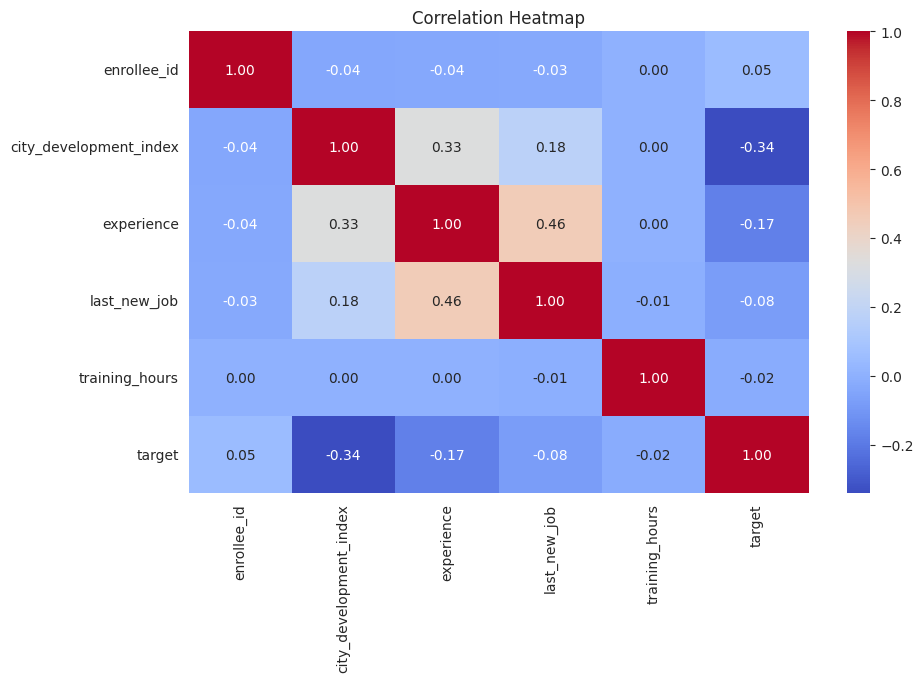

In [125]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
# Select only numerical columns for correlation calculation
numerical_df = train_df.select_dtypes(include=['number'])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


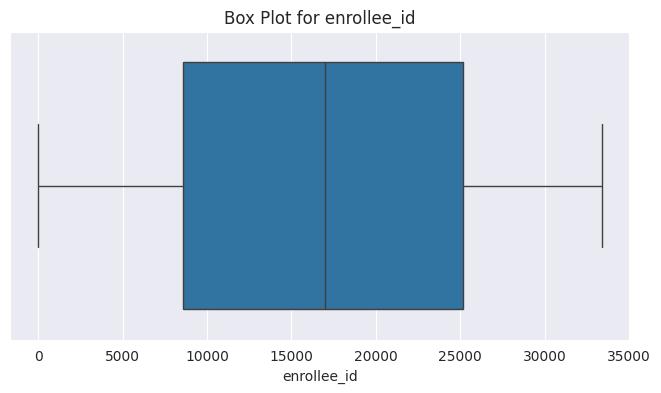

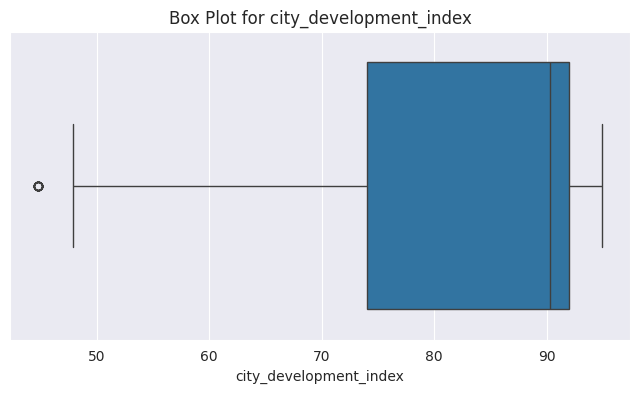

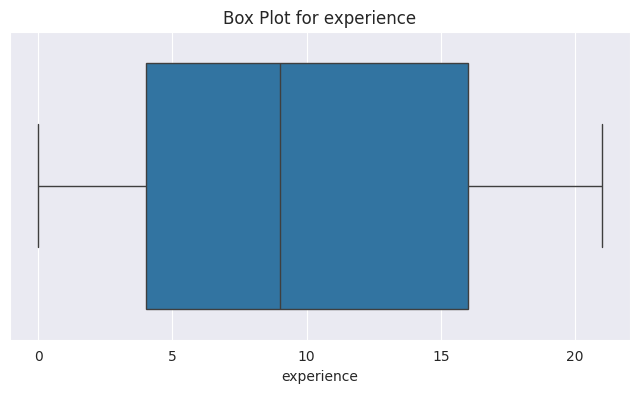

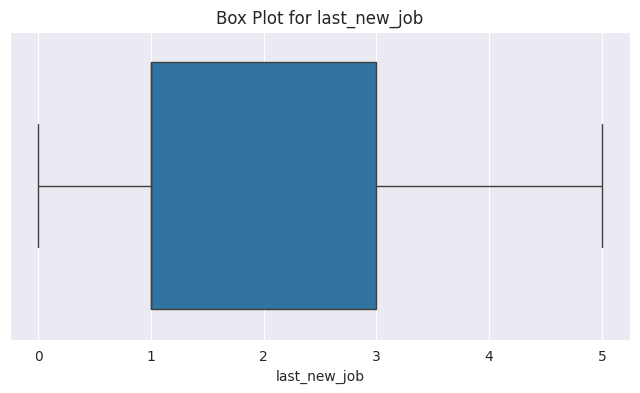

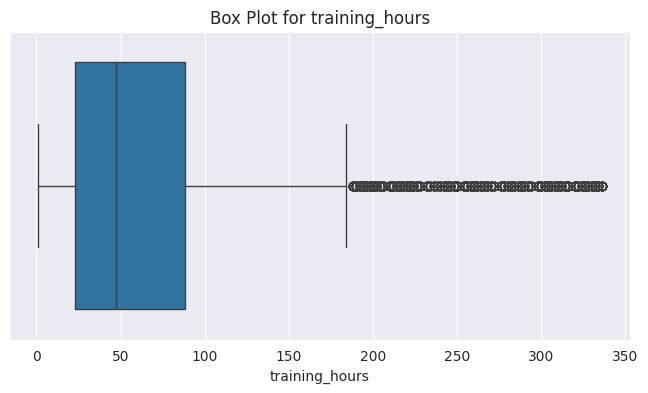

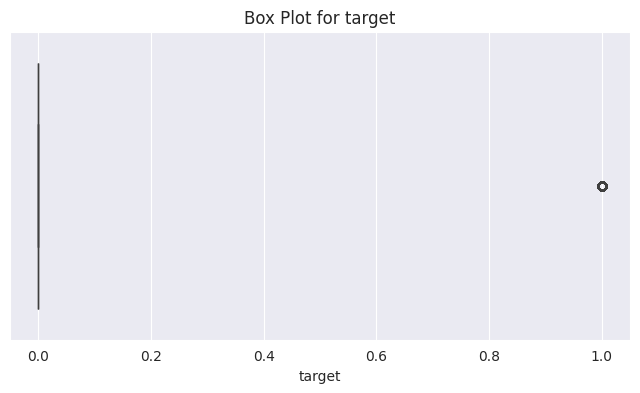

In [126]:
# Box plots for outliers detection
numerical_columns = train_df.select_dtypes(include=['number']).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[col])
    plt.title(f"Box Plot for {col}")
    plt.show()

In [128]:
# Outlier Detection using Z-score
from scipy.stats import zscore
train_df_numeric = train_df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(train_df_numeric))
train_df = train_df[(z_scores < 3).all(axis=1)]
print("Shape after removing outliers:", train_df.shape)

Shape after removing outliers: (18420, 13)


# Outlier Treatment

In [129]:
# Outlier Treatment
for col in train_df_numeric.columns:
    Q1 = train_df_numeric[col].quantile(0.25)
    Q3 = train_df_numeric[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df_numeric[col] = np.where(train_df_numeric[col] < lower_bound, lower_bound, train_df_numeric[col])
    train_df_numeric[col] = np.where(train_df_numeric[col] > upper_bound, upper_bound, train_df_numeric[col])



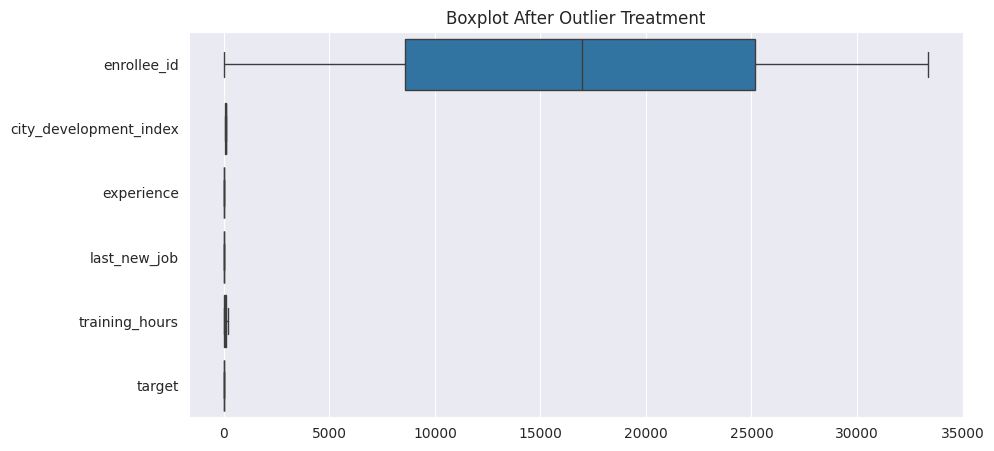

In [130]:
# Boxplot to visualize treated outliers
plt.figure(figsize=(10, 5))  # Adjust figure size for horizontal layout
sns.boxplot(data=train_df_numeric, orient='h')  # Set orient to 'h'
plt.yticks(rotation=0)  # Rotate y-axis labels if needed
plt.title('Boxplot After Outlier Treatment')
plt.show()

# Encoding

In [131]:
# Label Encoding for Binary Columns
le = LabelEncoder()
train_df['relevent_experience'] = le.fit_transform(train_df['relevent_experience'])
test_df['relevent_experience'] = le.transform(test_df['relevent_experience'])  # Use the same encoder for test data


In [132]:
# One-Hot Encoding for Nominal Columns (No natural order)
one_hot_columns = ['gender', 'enrolled_university', 'major_discipline', 'company_type']

train_df = pd.get_dummies(train_df, columns=one_hot_columns, drop_first=True)
test_df = pd.get_dummies(test_df, columns=one_hot_columns, drop_first=True)


In [139]:
target_enc = ce.TargetEncoder()
# Assuming 'target' is the intended target column name
train_df['education_level'] = target_enc.fit_transform(train_df['education_level'], train_df['target'])
test_df['education_level'] = target_enc.transform(test_df['education_level'])

train_df['company_size'] = target_enc.fit_transform(train_df['company_size'], train_df['target'])
test_df['company_size'] = target_enc.transform(test_df['company_size'])


# Splitting Test & Train

In [140]:
# Splitting data into train and test
X = train_df.drop(columns=['target'])
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# SMOTE - (Synthetic Minority Over-sampling Technique)

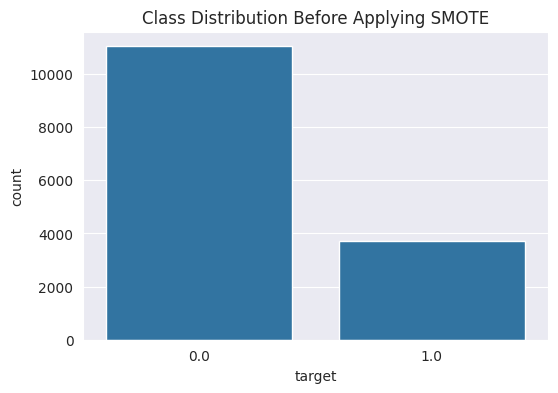

In [141]:
# Check Data Imbalance before SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title('Class Distribution Before Applying SMOTE')
plt.show()



In [142]:
# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Model Building

In [143]:
# Hyperparameter tuning settings (example parameters, modify as needed)
param_grid = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
    },
    'LightGBM': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
    }
}


Training Logistic Regression...


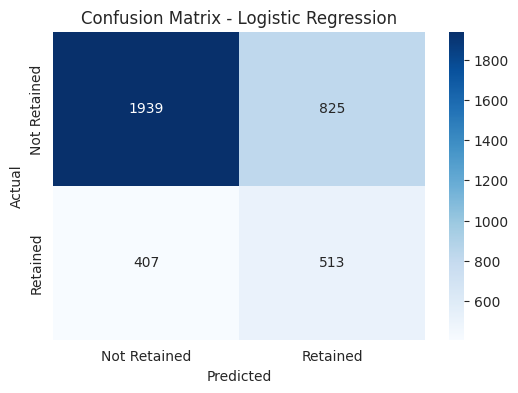

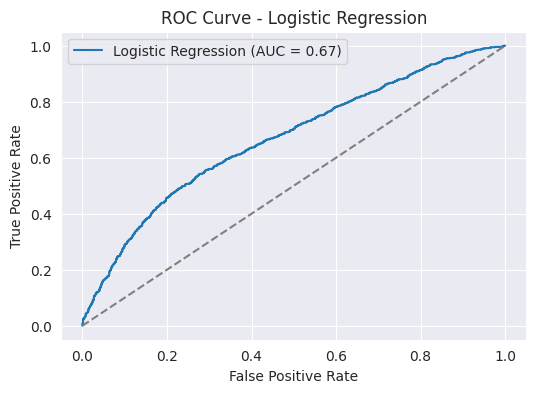

Logistic Regression Accuracy: 0.67, F1 Score: 0.45, Precision: 0.38, AUC: 0.67

Training Decision Tree...


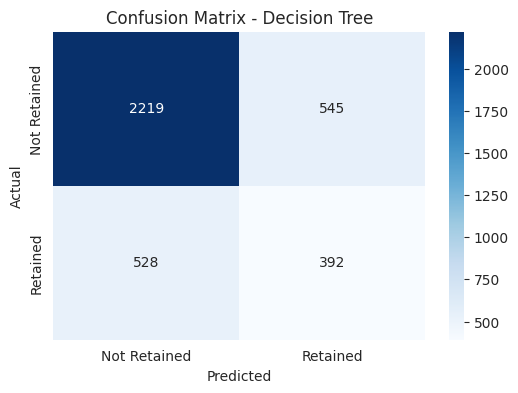

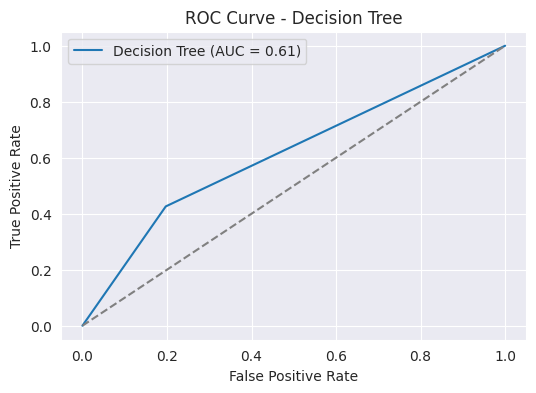

Decision Tree Accuracy: 0.71, F1 Score: 0.42, Precision: 0.42, AUC: 0.61

Training Random Forest...


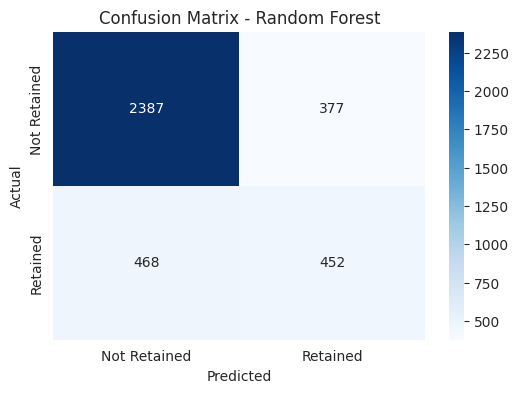

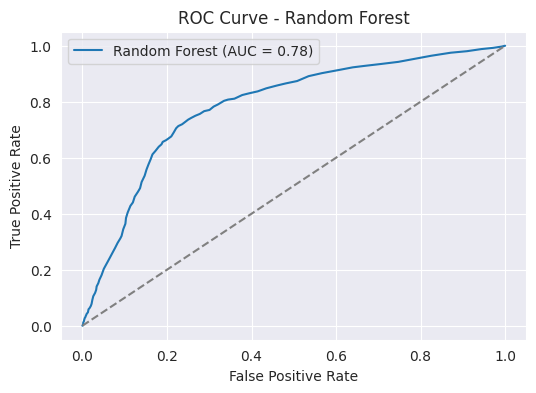

Random Forest Accuracy: 0.77, F1 Score: 0.52, Precision: 0.55, AUC: 0.78

Training XGBoost...


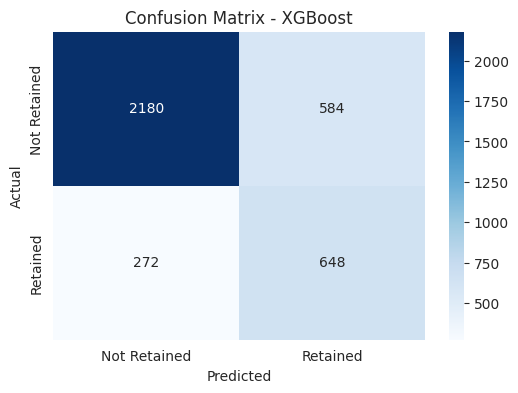

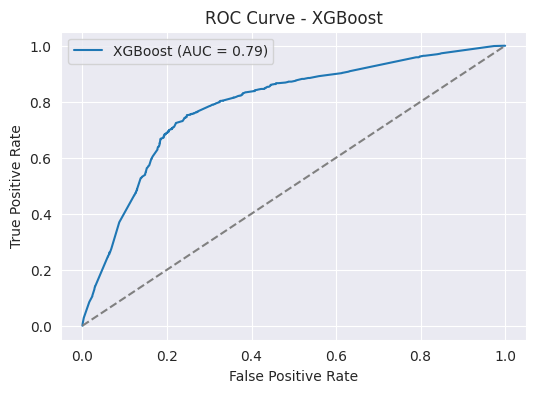

XGBoost Accuracy: 0.77, F1 Score: 0.60, Precision: 0.53, AUC: 0.79

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7357, number of negative: 7357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 14714, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7358, number of negative: 7357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is no

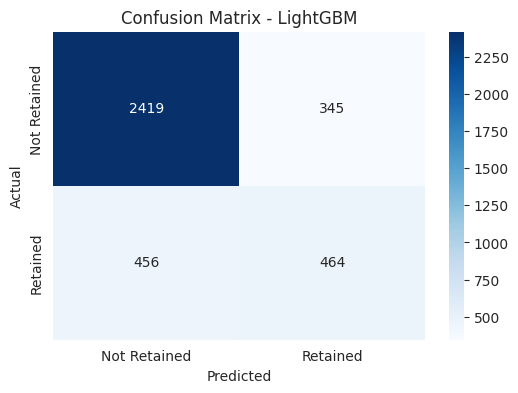

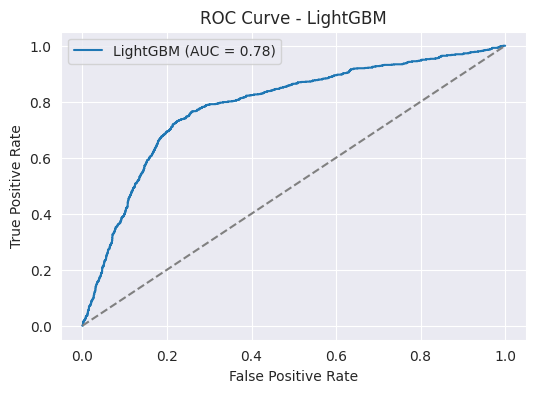

LightGBM Accuracy: 0.78, F1 Score: 0.54, Precision: 0.57, AUC: 0.78


In [144]:
# Building ML Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    if name in param_grid:
        # Use RandomizedSearchCV instead of GridSearchCV if you want to use n_iter
        search = RandomizedSearchCV(model, param_distributions=param_grid[name], cv=3, scoring='accuracy', n_iter=5, random_state=42)
        search.fit(X_train, y_train)
        model = search.best_estimator_
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Retained', 'Retained'], yticklabels=['Not Retained', 'Retained'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # ROC Curve & AUC Score
    if y_pred_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc_score = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()
    else:
        auc_score = None

    results[name] = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'AUC': auc_score}
    print(f'{name} Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}, AUC: {auc_score:.2f}' if auc_score else f'{name} Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}')


In [145]:
# Display summary results
df_results = pd.DataFrame(results).T
print("\nModel Performance Summary")
print(df_results)


Model Performance Summary
                     Accuracy  F1 Score  Precision       AUC
Logistic Regression  0.665581  0.454384   0.383408  0.667058
Decision Tree        0.708740  0.422186   0.418356  0.614454
Random Forest        0.770630  0.516867   0.545235  0.783750
XGBoost              0.767644  0.602230   0.525974  0.789340
LightGBM             0.782573  0.536726   0.573548  0.784775


# Submission